In [44]:
import pandas as pd 
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.gridspec import GridSpec
plt.rcParams['font.family'] = 'Arial'

import dataframe_image as dfi

from selenobot.files import XMLFile, KofamscanFile
from selenobot.utils import seed 
from selenobot.datasets import Dataset, get_dataloader
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from tqdm import tqdm
from scipy.stats import false_discovery_control, mannwhitneyu

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
label_map = dict()
label_map[0] = 'full-length'
label_map[1] = 'trunc. sel.'
label_map[2] = 'short full-len.'

color_map = {1:'tab:red', 2:'tab:blue', 0:'tab:green'}
color_map.update({'train':'tab:red', 'test':'tab:blue', 'val.':'tab:green'})
color_map.update({'evidence at protein level':'tab:green', 'inferred from homology':'tab:blue', 'predicted':'tab:red', 'evidence at transcript level':'tab:green', 'uncertain':'black'})

datasets = ['train', 'test', 'val.']

In [3]:
metadata_3c = dict()
metadata_3c['train'] = pd.read_csv('../data/3c_metadata_train.csv', index_col=0)
metadata_3c['test'] = pd.read_csv('../data/3c_metadata_test.csv', index_col=0)
metadata_3c['val.'] = pd.read_csv('../data/3c_metadata_val.csv', index_col=0)

metadata_2c = dict()
metadata_2c['train'] = pd.read_csv('../data/2c_metadata_train.csv', index_col=0)
metadata_2c['test'] = pd.read_csv('../data/2c_metadata_test.csv', index_col=0)
metadata_2c['val.'] = pd.read_csv('../data/2c_metadata_val.csv', index_col=0)

In [46]:
metadata_sec_df = pd.read_csv('../data/uniprot_metadata_sec.csv', index_col=0)
metadata_sec_bac_df = metadata_sec_df[metadata_sec_df.domain == 'Bacteria']
metadata_sec_bac_df = metadata_sec_df.merge(KofamscanFile('../data/uniprot_sec_bacteria.ko.tsv').to_df(), left_index=True, right_index=True, how='left')

In [ ]:
def table_1(metadata_sec_bac_df:pd.DataFrame, reduce:bool=False, path:str='../figures/datasets-table_1.png'):

    ko_map = dict()
    ko_map['formate dehydrogenase (hydrogenase) '] = 'formate dehydrogenase'
    ko_map['F420-non-reducing hydrogenase iron-sulfur subunit '] = 'hydrogenase'
    ko_map['formate dehydrogenase (coenzyme F420) alpha subunit '] = 'formate dehydrogenase' 
    ko_map['betaine reductase complex component B subunit beta '] = 'reductase'
    ko_map['NADH-dependent peroxiredoxin subunit C '] = 'peroxiredoxin'
    ko_map['sulfur-carrier protein adenylyltransferase/sulfurtransferase '] = 'adenylyltransferase'
    ko_map['molybdopterin-synthase adenylyltransferase '] = 'adenylyltransferase' 
    ko_map['F420-non-reducing hydrogenase large subunit '] = 'hydrogenase'
    ko_map['formate dehydrogenase (NAD+, ferredoxin) subunit '] = 'formate dehydrogenase'
    ko_map['sarcosine reductase complex component B subunit beta '] = 'reductase'
    ko_map['CoA-dependent NAD(P)H sulfur oxidoreductase '] = 'oxioreductase'
    ko_map['mycoredoxin-dependent peroxiredoxin '] = 'peroxiredoxin'
    ko_map['NFU1 iron-sulfur cluster scaffold homolog, mitochondrial'] = 'other'
    ko_map['regulatory protein spx'] = 'other'
    ko_map['P-type Cu+ transporter '] = 'other'
    ko_map['methane/ammonia monooxygenase subunit A '] = 'monooxygenase' 
    ko_map['glutaredoxin-dependent peroxiredoxin '] = 'peroxiredoxin' 
    ko_map['mycoredoxin '] = 'mycoredoxin'
    ko_map['thioredoxin-dependent peroxiredoxin '] = 'peroxiredoxin'
    ko_map['multidrug efflux pump'] = 'other'
    ko_map['methylamine---corrinoid protein Co-methyltransferase '] = 'methyltransferase' 
    ko_map['nucleoredoxin '] = 'nucleoredoxin'
    ko_map['TetR/AcrR family transcriptional regulator, transcriptional repressor for nem operon'] = 'other'
    ko_map['alcohol dehydrogenase (NADP+) '] = 'dehydrogenase'
    ko_map['sulfonate transport system permease protein'] = 'transport'
    ko_map['3-hydroxy acid dehydrogenase / malonic semialdehyde reductase '] = 'reductase'
    ko_map['alcohol dehydrogenase, propanol-preferring '] = 'dehydrogenase'
    ko_map['arsenical resistance protein ArsH'] = 'other'
    ko_map['tRNA 2-thiocytidine biosynthesis protein TtcA'] = 'other'
    ko_map['quinone-modifying oxidoreductase, subunit QmoA'] = 'oxioreductase'
    ko_map['acetate---CoA ligase (ADP-forming) '] = 'other'
    ko_map['glutaredoxin/glutathione-dependent peroxiredoxin '] = 'peroxiredoxin'
    ko_map['thioredoxin-dependent peroxiredoxin '] = 'peroxiredoxin'
    ko_map['phospholipid scramblase'] = 'other'

    ko_counts = pd.Series(metadata_sec_bac_df.value_counts('ko'), name='count')
    table_df = metadata_sec_bac_df[['ko', 'ko_definition']]
    table_df = table_df.merge(ko_counts, right_index=True, left_on='ko', how='right')
    table_df = table_df.drop_duplicates('ko').set_index('ko') # .rename(columns={'ko':'KO', 'ko_definition':'KO definition'})
    table_df.ko_definition = table_df.ko_definition.str.replace(r'\[EC:.*\]', '', regex=True)
    
    if reduce:
        table_df.ko_definition = table_df.ko_definition.replace(ko_map)
        table_df = table_df.groupby('ko_definition').apply(np.sum, include_groups=False, axis=0)
        table_df = table_df.sort_values('count', ascending=False)
    
    table_df.index.name = 'KO'
    table_df = table_df.rename(columns={'ko_definition':'KO definition'})
    dfi.export(table_df, path)

table_1(metadata_sec_bac_df, reduce=True, path='../figures/datasets-table_1_reduced.png')
table_1(metadata_sec_bac_df, reduce=False, path='../figures/datasets-table_1.png')
    

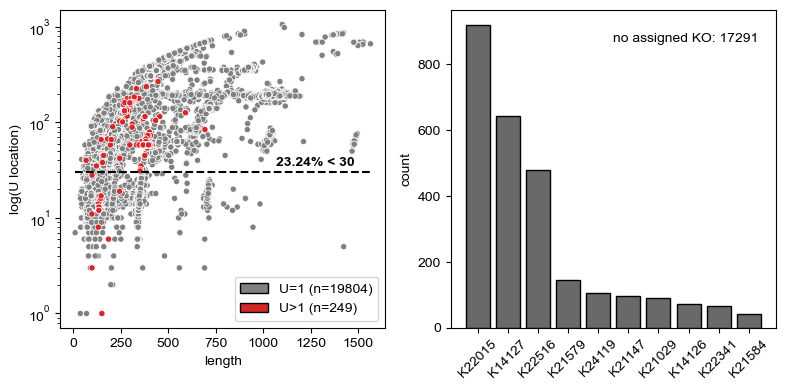

In [39]:
# NOTE: Would it be more informative to plot this after de-replicating?
def figure_1(metadata_sec_df:pd.DataFrame, min_length:int=30, path:str='../figures/datasets-figure_1.png'):
    '''Useful to characterize the known selenoproteins in UniProt.''' 
    fig = plt.figure(layout='tight', figsize=(8, 4))
    grid = GridSpec(nrows=1, ncols=2, figure=fig)

    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = fig.add_subplot(grid[:, 1]) # Axis to show the top KO groups.
    # ax_c = fig.add_subplot(grid[1, 1])

    metadata_sec_df['sec_count'] = [seq.count('U') for seq in metadata_sec_df.seq]
    metadata_sec_df['sec_idx'] = [seq.index('U') for seq in metadata_sec_df.seq]
    metadata_sec_df['length'] = metadata_sec_df.seq.apply(len)
    metadata_sec_df = metadata_sec_df.sort_values('sec_count') # Sort so that the red-labeled points are plotted in front.

    ax_a.scatter(metadata_sec_df.length, metadata_sec_df.sec_idx, s=20, edgecolor='white', lw=0.5, c=['gray' if (count == 1) else 'tab:red' for count in metadata_sec_df.sec_count])
    ax_a.hlines([min_length], ls='--', xmin=metadata_sec_df.length.min(), xmax=metadata_sec_df.length.max(), color='black', lw=1.5)
    ax_a.text(metadata_sec_df.length.max() - 500, min_length + 5, f'{100 * (metadata_sec_df.sec_idx < min_length).sum() / len(metadata_sec_df):.2f}% < {min_length}', fontweight='bold')
    ax_a.set_ylabel('log(U location)')
    ax_a.set_xlabel('length')
    ax_a.set_yscale('log')

    n_gt_1, n_eq_1 = (metadata_sec_df.sec_count > 1).sum(), (metadata_sec_df.sec_count == 1).sum()
    ax_a.legend(handles=[Patch(facecolor='gray', edgecolor='black', label=f'U=1 (n={n_eq_1})'), Patch(facecolor='tab:red', edgecolor='black', label=f'U>1 (n={n_gt_1})')])

    n_no_ko = metadata_sec_df.ko.isnull().sum()
    heights = metadata_sec_df.ko.value_counts(dropna=True).values[:10]
    kos = metadata_sec_df.ko.value_counts(dropna=True).index[:10]
    positions = np.arange(len(kos))
    ax_b.bar(positions, heights, color='dimgray', edgecolor='black')
    ax_b.set_xticks(positions, kos, rotation=45)
    ax_b.set_ylabel('count')
    ax_b.text(0.5, 0.9, f'no assigned KO: {n_no_ko}', transform=ax_b.transAxes)

    plt.show()


figure_1(metadata_sec_bac_df)

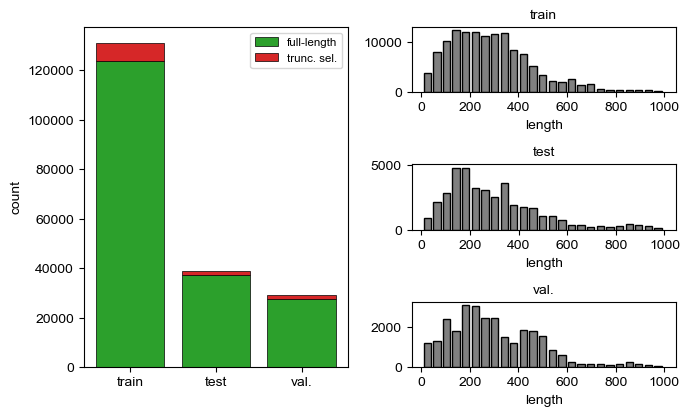

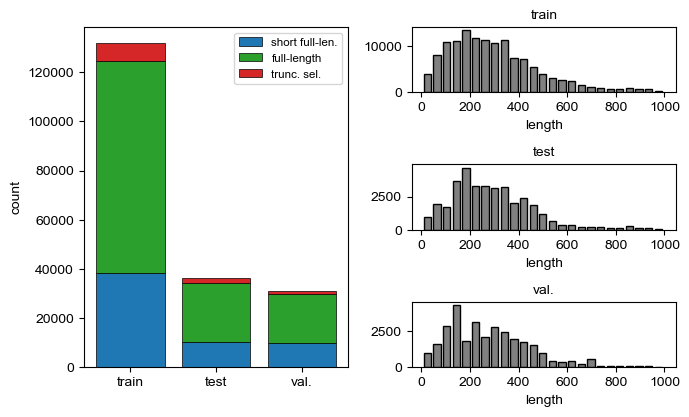

In [40]:
def figure_2(metadata:dict, path:str='../figures/datasets-figure_2.png'):
    '''Illustrating the composition of each split dataset.'''

    fig = plt.figure(layout='tight', figsize=(7, 8))
    grid = GridSpec(6, 2, figure=fig)

    ax_a = fig.add_subplot(grid[:3, 0])
    ax_b = [fig.add_subplot(grid[i, 1]) for i in range(0, 3)]

    labels = metadata['train'].label.unique()

    positions = np.arange(3)
    bottom = np.zeros(3)
    for label in labels:
        heights = np.array([(metadata[dataset]['label'] == label).sum() for dataset in datasets])
        ax_a.bar(positions, heights, bottom=bottom, color=color_map[label], edgecolor='black', lw=0.5)
        bottom += heights 

    ax_a.set_ylabel('count')
    ax_a.set_xticks(positions, datasets)
    ax_a.legend([label_map[label] for label in labels], loc='upper right', fontsize='small')

    for ax, dataset in zip(ax_b, datasets):
        ax.hist(metadata[dataset].seq.apply(len), bins=25, lw=0.5, edgecolor='black', color='gray', width=30)
        ax.set_title(dataset, fontsize='medium')
        # ax.set_ylabel('count')
        ax.set_xlabel('length')
    
    fig.savefig(path)
    plt.show()


figure_2(metadata_2c, path='../figures/datasets-figure_2_2c.png')
figure_2(metadata_3c, path='../figures/datasets-figure_2_3c.png')


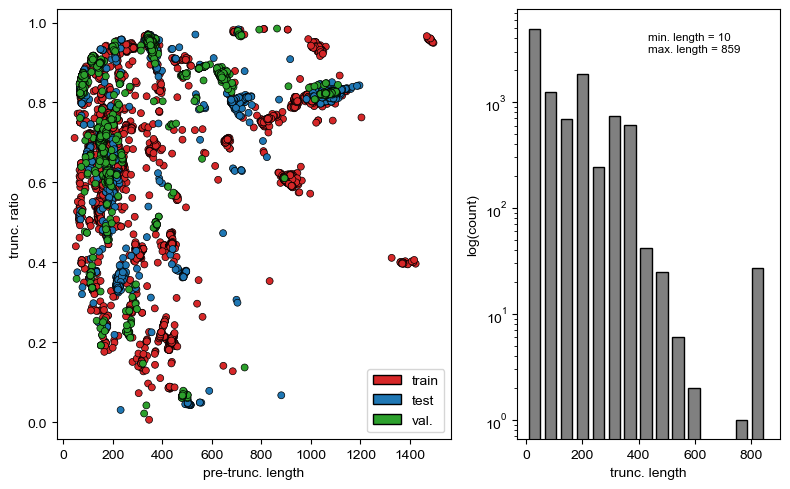

In [35]:
# What are the truncation ratio distributions for the selenoprotein? How short is the shortest one?

def figure_3()
metadata_2c_1_df = pd.concat([df[df.label == 1].assign(dataset=dataset) for dataset, df in metadata_2c.items()]) # Grab all truncated selenoproteins. 
metadata_2c_0_df = pd.concat([df[df.label == 0].assign(dataset=dataset) for dataset, df in metadata_2c.items()]) # Grab all truncated selenoproteins. 

fig, axes = plt.subplots(ncols=2, figsize=(8, 5), width_ratios=[0.6, 0.4], layout='tight')

ax = axes[0]

colors = metadata_2c_1_df.dataset.replace(color_map).values
ax.scatter(metadata_2c_1_df.original_length, metadata_2c_1_df.truncation_ratio, s=25, c=colors, edgecolors='black', lw=0.5)
ax.set_xlabel('pre-trunc. length')
ax.set_ylabel('trunc. ratio')
ax.legend(handles=[Patch(facecolor=color_map[dataset], label=dataset, edgecolor='black') for dataset in datasets], loc='lower right')

ax = axes[1]
ax.hist(metadata_2c_1_df.seq.apply(len), bins=15, width=40, edgecolor='black', color='gray')
ax.set_ylabel('log(count)')
ax.set_xlabel('trunc. length')
ax.set_yscale('log')
ax.text(0.5, 0.9, f'min. length = {metadata_2c_1_df.seq.apply(len).min()}\nmax. length = {metadata_2c_1_df.seq.apply(len).max()}', transform=ax.transAxes, fontsize='small')

plt.show()

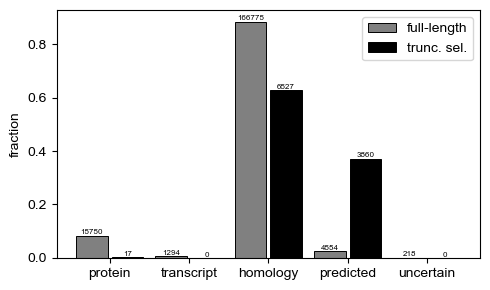

In [9]:
# I think it also might be valuable to assess sequence quality... 

def figure_3(metadata:dict):

    fig, ax = plt.subplots(figsize=(5, 3), layout='tight')

    metadata_df = pd.concat(list(metadata.values())) # Grab all metadata. 
    labels = metadata_df.label.unique()

    cats = ['evidence at protein level', 'evidence at transcript level', 'inferred from homology', 'predicted', 'uncertain']
    cats_map = {'evidence at protein level':'protein', 'evidence at transcript level':'transcript', 'inferred from homology':'homology', 'predicted':'predicted', 'uncertain':'uncertain'} 

    bar_width = 0.4
    sep = 0.05
    positions = np.arange(len(cats))
    color_map = {0:'gray', 1:'black'}
    
    for label, df in metadata_df.groupby('label'):
        counts = np.array([(df.existence == cat).sum() for cat in cats])
        heights = counts / len(df)
        positions_ = positions + label * (bar_width + sep) 
        ax.bar(positions_, heights, label=label_map[label], color=color_map[label], width=bar_width, edgecolor='black', lw=0.7)

        for x, y, n in zip(positions_, heights, counts):
            ax.text(x, y + 0.005, str(n), fontsize='xx-small', ha='center')

    ax.set_xticks(positions + (bar_width + sep) / 2, labels=[cats_map[cat] for cat in cats])
    ax.set_ylabel('fraction')
    ax.legend(labels=[label_map[label] for label in labels])

    plt.show()


figure_3(metadata_2c)